In [2]:
import dill as pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio

In [2]:
class DynamicIV:
    
    def __init__(self, model):
        
        self.phi = model.fda_model.phi
        self.psi = model.fda_model.psi
        self.mean = model.fda_model.mean
        
        self.delta = model.delta
        self.tau = model.tau
        
        self.delta_range = np.arange(0.01,1,step=0.01)
        self.delta_range_t = self.__Transform_Delta__(self.delta_range)
        
        self.delta_t = self.__Transform_Delta__(self.delta)
        self.tau_t = self.__Transform_Tau__(self.tau)
        
        self.tickers = model.tickers
        self.K = model.K
        
        self.nrm = model.nrm
        self.reg = model.reg
        
        self.b = model.b
        
    
    def __Transform_Delta__(self, delta):
        
        return 2*delta-1
    
    def __Recover_Delta__(self, delta_t):
        
        return 0.5*delta_t+0.5
    
    def __Transform_Tau__(self, tau):
        
        return 2*np.sqrt(tau)/np.max(np.sqrt(self.tau)) - 1
    
    def __Recover_Tau__(self, tau_t):
        
        return np.square((tau_t+1)*np.max(np.sqrt(self.tau))*0.5) 
    
    def __UnNormalise__(self, a, b, X):
        
        return  (X -a)/b
        
    def __Recover_IV__(self, ticker_idx, IV_t):
        
        return np.log(1+ np.exp(self.__UnNormalise__(*self.nrm[ticker_idx]['IV'], IV_t)))
    
    def __Plot_IV_Surfaces__(self, b, scenario, delta=np.arange(0.0,1.01,0.01), tau=np.arange(1/365, 731/365, 1/365), save_fig=True):
        
        delta_t = self.__Transform_Delta__(delta)
        tau_t = self.__Transform_Tau__(tau)
        
        delta_grid_t, tau_grid_t = np.meshgrid(delta_t, tau_t)
        delta_grid, tau_grid = np.meshgrid(delta, tau)
        
        def __Calculate_IV_on_Grid__(b):
            
            IV_fit = np.zeros((b.shape[0], b.shape[1], delta_grid.shape[0], delta_grid.shape[1]))
            
            IV_fit[:,:] = self.mean(delta_grid_t, tau_grid_t)
            for i in range(b.shape[-1]):
                IV_fit += np.matmul(b[:,:,i].reshape(-1,1), self.psi[i](delta_grid_t,tau_grid_t).reshape(1,-1)).reshape(b.shape[0], b.shape[1], delta_grid.shape[0], delta_grid.shape[1])

            return IV_fit 
        
        def __IV_Per_Ticker__(b, ticker_idx):
            
            b = b[:,:,:-1]
            IV_t = __Calculate_IV_on_Grid__(b=b)
            IV = self.__Recover_IV__(ticker_idx, IV_t) 
            
            return IV
            
        seq_length = int(b.shape[-1]/len(self.tickers))
        IV = []
        
        for i in range(len(self.tickers)):
            
            IV_i = __IV_Per_Ticker__(b[:,:,i*seq_length:(i+1)*seq_length], i) 
            IV.append(IV_i)

        filenames = []
         
        for j in range(b.shape[1]):
            
            fig, ax = plt.subplots(figsize=(30,10), nrows=1, ncols=4, subplot_kw={"projection":"3d"})
            if j==0:
                fig.suptitle('Day 0 (last observed surface)', color='k', size=40)
            else:
                fig.suptitle('Day %s' %j, color='k', size=40)
            
            for i in range(len(self.tickers)):
                
                ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))
                ax[i].yaxis.set_major_locator(plt.MaxNLocator(4))
                ax[i].zaxis.set_major_locator(plt.MaxNLocator(4))
                ax[i].plot_surface(delta_grid, tau_grid, IV[i][0,j], linewidth=0, cmap=cm.coolwarm, antialiased=True)
                ax[i].set_zlim(round(np.min(IV[i][0]),1)-0.1, np.ceil(np.max(IV[i][0])*10)/10)
                ax[i].tick_params(axis='both', which='major', labelsize=20)
                ax[i].tick_params(axis='z', which='major', labelsize=20, pad=10)
                ax[i].set_title(self.tickers[i], fontsize=40)
                
                if i==0:
                    ax[i].set_ylabel(r"$\tau$", fontsize=30, labelpad=20)
                    ax[i].set_xlabel(r"$\delta$", fontsize=30, labelpad=20)
                    ax[i].set_zlabel(r"$\sigma$", fontsize=30, labelpad=25)
            
            plt.show()
            
            filename = "Simulated_" + str(j) + ".png"
            filenames.append(filename)
            if save_fig:
                fig.savefig(filename) 
            
            with imageio.get_writer('iv_scenario_%s.gif' %scenario, mode='I', fps=2, loop=1) as writer:
                for filename in filenames:
                    image = imageio.imread(filename)
                    writer.append_data(image)
            
        return delta_grid, tau_grid, IV
    
    def __Plot_Price_Path__(self, price, scenario, save_fig=True):
        
        fig = plt.figure(figsize=(20, 5))
        
        for i in range(len(self.tickers)):
            
            plt.subplot(1,4,i+1)
            plt.plot(price[:, i])
            plt.title(model.tickers[i], fontsize=25)
            plt.xticks(fontsize=15)
            # plt.yticks(fontsize=15)
            
            if i==0:
                plt.ylabel('Price', fontsize=20)
                plt.yticks(fontsize=15)
            if i==1:
                plt.yticks(fontsize=15)
            if i==2:
                plt.yticks(fontsize=15)
            if i==3:
                plt.yticks(fontsize=15)
                
            
            # plt.locator_params(axis='y', nbins=4)

        plt.tight_layout(pad=1.5)
        fig.supxlabel('Days', y=0.001, fontsize=18)
        if save_fig:
            plt.savefig("price_scenario_%s" %scenario)
        plt.show()

In [ ]:
# Load the saved model
with open('data/dynamicIV.pkl', 'rb') as inp:    
    model = pickle.load(inp)
    
# load the simulated FPC coefficients and transformed prices
with open('data/sim_data_coeffs.npy', 'rb') as f:
    b_sim = np.load(f)
    
""" b_sim is 5000 x 30 x36 dimensional
The first index upto 5000 corresponds to 5000 generated (independent) scenarios
The second index corresponds to the sequence of days where day 0 is the last day of training (observed) and the remaining 29 days are generated coefficients
Hence day 0 will give the FPC coefficients (FPCCs) for the IV surface that is observed on the last day of training and is not a synthetic generated surface
The last index corresponds to the different assets' FPCCs and transformed equity prices, details for third index below:
0-7 give FPCCs for AMZN, 8 gives transformed equity price for AMZN
9-16 give FPCCs for IBM, 17 gives transformed equity price for IBM
18-25 give FPCCs for INTC, 26 gives transformed equity price for INTC
27-34 give FPCCs for TSLA, 35 gives transformed equity price for TSLA """

with open('data/sim_data_prices.npy', 'rb') as f:
    price_sim = np.load(f)
    
# """ price_sim is 5000 x 30 x 4
# The first index upto 5000 corresponds to 5000 generated (independent) scenarios
# The second index corresponds to the sequence of days where day 0 is the last day of training (observed) and the remaining 29 days are generated coefficients
# The last index correspond to the different equities """

# """ To get the IV surfaces as well as its values on a grid for scenario k"""
k = 1
delta_grid, tau_grid, IV = model.__Plot_IV_Surfaces__(b_sim[k:k+1,:,:], scenario=k+1, delta=np.arange(0.0,1.01,0.05), tau=np.arange(1/365, 731/365, 30/365))

""" To get the price path plots for scenario k"""
# model.__Plot_Price_Path__(price_sim[k],k+1)

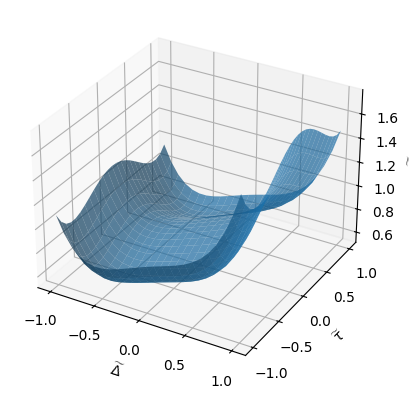

In [8]:
X_fit_FPC, Y_fit_FPC, Z_fit_FPC = model.fda_model.Generate_FPC_Surface(b_sim[1,1,0:8])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X_fit_FPC, Y_fit_FPC, Z_fit_FPC, linewidth=0, antialiased=True, alpha=0.7)
ax.set_xlabel(r"$\widetilde{\Delta}$")
ax.set_ylabel(r"$\widetilde{\tau}$")
ax.set_zlabel(r"$\widetilde{\sigma}$")

plt.show()

In [5]:
tickers = ['AMZN', 'IBM', 'INTC', 'TSLA']
for i, ticker in enumerate(tickers):
    print("{}, {}".format(i, ticker))


0, AMZN
1, IBM
2, INTC
3, TSLA
